# High-Accuracy Model: Predict Critic Positivity/Negativity (All Variables)

This notebook builds a **high-accuracy** classifier for critic sentiment (**POSITIVE** vs **NEGATIVE**) using **all available variables**, including:

- Review metadata (e.g., `isTopCritic`, `originalScore`, `reviewState`, etc.)
- Movie metadata (e.g., `tomatoMeter`, `audienceScore`, `genre`, `runtimeMinutes`, etc.)
- **Review text** (`reviewText`) using TF‑IDF features

It uses an end-to-end `Pipeline` with:
- `TfidfVectorizer` for text
- `OneHotEncoder` for categorical variables
- `SimpleImputer` for missing values
- Logistic Regression optimized for sparse features

Outputs are saved to an `output/` folder.


In [7]:
# If needed (run once):
# !pip install pandas numpy scikit-learn matplotlib joblib

import re
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, RocCurveDisplay
)
import joblib


In [8]:
OUTPUT_DIR = Path("output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def safe_filename(name: str) -> str:
    name = re.sub(r'[<>:"/\\|?*]', '', name)
    return name.replace(" ", "_")

print("Output folder:", OUTPUT_DIR.resolve())


Output folder: C:\Users\chank\github\DataScienceProject\scripts\output


In [9]:
# Load data (update these paths if needed)
movies_path = Path("../data/rotten_tomatoes_movies.csv")
reviews_path = Path("../data/rotten_tomatoes_movie_reviews.csv")

movies = pd.read_csv(movies_path)
reviews = pd.read_csv(reviews_path)

df = reviews.merge(movies, on="id", how="inner")
print("Merged:", df.shape)
df.head()


Merged: (1469543, 26)


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,...,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,...,NaN,2011-06-21,30.0,Documentary,English,Stephen Low,NaN,NaN,NaN,NaN
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN


## Target: `scoreSentiment` (POSITIVE/NEGATIVE)

In [10]:
df = df[df["scoreSentiment"].isin(["POSITIVE", "NEGATIVE"])].copy()
y = df["scoreSentiment"]
print(y.value_counts())


scoreSentiment
POSITIVE    980223
NEGATIVE    489320
Name: count, dtype: int64


## Features: all columns except obvious IDs/URLs and the target

In [ ]:
drop_cols = [
    "scoreSentiment",  # target
    "reviewState",     # direct label proxy
    "originalScore",   # rating directly determines sentiment
    "tomatoMeter",     # aggregate of the same label
]
X = df.drop(columns=[c for c in drop_cols if c in df.columns]).copy()

# Make sure some common numeric-looking columns are numeric
for col in ["audienceScore", "tomatoMeter", "runtimeMinutes", "boxOffice"]:
    if col in X.columns:
        X[col] = pd.to_numeric(X[col], errors="coerce")

TEXT_COL = "reviewText"


numeric_cols = X.select_dtypes(include=["number", "bool"]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols and c != TEXT_COL]

print("Numeric:", len(numeric_cols), "Categorical:", len(categorical_cols), "Text:", TEXT_COL in X.columns)

print(X.columns)



Numeric: 5 Categorical: 17 Text: True
Index(['id', 'creationDate', 'criticName', 'isTopCritic', 'originalScore',
       'reviewState', 'publicatioName', 'reviewText', 'title', 'audienceScore',
       'tomatoMeter', 'rating', 'ratingContents', 'releaseDateTheaters',
       'releaseDateStreaming', 'runtimeMinutes', 'genre', 'originalLanguage',
       'director', 'writer', 'boxOffice', 'distributor', 'soundMix'],
      dtype='str')


In [19]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

# had to flatten to 1d because it was getting 2d inputs
def flatten_to_1d(x):
    # x can be DataFrame/ndarray with shape (n,1) -> return (n,)
    if isinstance(x, pd.DataFrame):
        return x.iloc[:, 0].astype(str)
    x = np.asarray(x)
    if x.ndim == 2 and x.shape[1] == 1:
        x = x[:, 0]
    return pd.Series(x).astype(str)


if TEXT_COL in X.columns:
    X[TEXT_COL] = X[TEXT_COL].fillna("").astype(str)

text_transformer = Pipeline(steps=[
    ("flatten", FunctionTransformer(flatten_to_1d, validate=False)),
    ("tfidf", TfidfVectorizer(
        max_features=200_000,
        ngram_range=(1, 2),
        min_df=2,
        stop_words="english"
    ))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
        ("txt", text_transformer, [TEXT_COL]) if TEXT_COL in X.columns else ("drop_txt", "drop", []),
    ],
    remainder="drop",
    sparse_threshold=0.3
)


## Train + Evaluate

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", LogisticRegression(
        solver="saga",
        max_iter=3000,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, list(clf.named_steps["model"].classes_).index("POSITIVE")]

report = classification_report(y_test, y_pred)
auc = roc_auc_score((y_test == "POSITIVE").astype(int), y_prob)

print(report)
print("ROC AUC:", auc)


c:\Users\chank\github\DataScienceProject\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['boxOffice']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\chank\github\DataScienceProject\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  warnings.warn(msg, category=FutureWarning)
c:\Users\chank\github\DataScienceProject\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['boxOffice']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(
c:\Users\chank\github\DataScienceProject\venv\Lib\site-packages\sklearn\impute\_base.py:641: UserWarning: Skipping features without any observed values: ['boxOffice']. At least one non-miss

              precision    recall  f1-score   support

    NEGATIVE       1.00      1.00      1.00     97864
    POSITIVE       1.00      1.00      1.00    196045

    accuracy                           1.00    293909
   macro avg       1.00      1.00      1.00    293909
weighted avg       1.00      1.00      1.00    293909

ROC AUC: 1.0


In [21]:
# Save report
report_path = OUTPUT_DIR / "classification_report_all_features.txt"
report_path.write_text(report + f"\nROC AUC: {auc:.4f}\n", encoding="utf-8")
print("Saved:", report_path.resolve())


Saved: C:\Users\chank\github\DataScienceProject\scripts\output\classification_report_all_features.txt


<Figure size 640x480 with 0 Axes>

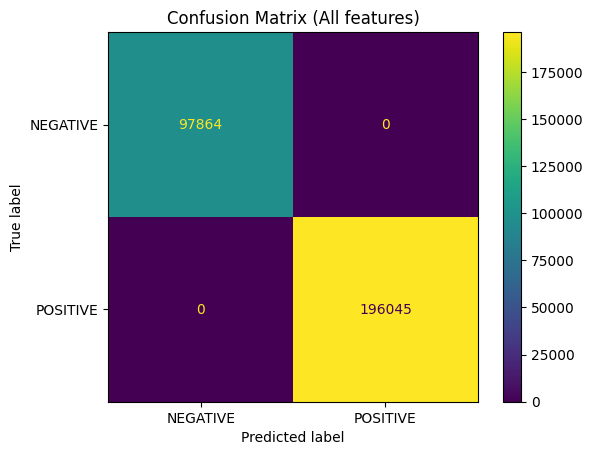

Saved: C:\Users\chank\github\DataScienceProject\scripts\output\confusion_matrix_all_features.png


In [22]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=["NEGATIVE", "POSITIVE"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEGATIVE", "POSITIVE"])

cm_path = OUTPUT_DIR / safe_filename("confusion_matrix_all_features.png")
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (All features)")
plt.savefig(cm_path, bbox_inches="tight")
plt.show()
print("Saved:", cm_path.resolve())


<Figure size 640x480 with 0 Axes>

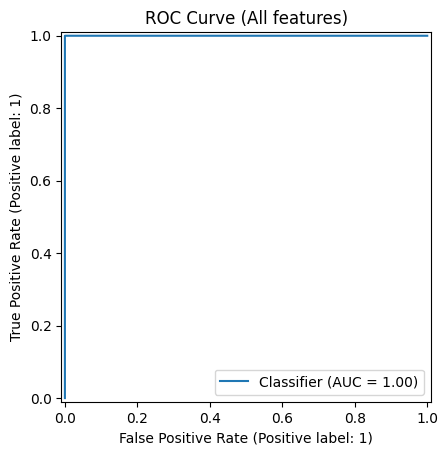

Saved: C:\Users\chank\github\DataScienceProject\scripts\output\roc_curve_all_features.png


In [23]:
# ROC plot
roc_path = OUTPUT_DIR / safe_filename("roc_curve_all_features.png")
plt.figure()
RocCurveDisplay.from_predictions((y_test == "POSITIVE").astype(int), y_prob)
plt.title("ROC Curve (All features)")
plt.savefig(roc_path, bbox_inches="tight")
plt.show()
print("Saved:", roc_path.resolve())


## Save model

In [24]:
model_path = OUTPUT_DIR / "critic_sentiment_model_all_features.joblib"
joblib.dump(clf, model_path)
print("Saved model:", model_path.resolve())


Saved model: C:\Users\chank\github\DataScienceProject\scripts\output\critic_sentiment_model_all_features.joblib


## Optional: Feature weights (can be large)

For Logistic Regression, coefficients show which features push toward POSITIVE vs NEGATIVE.
This saves a CSV of all feature weights, and displays the top 30 by absolute value.


In [25]:
import pandas as pd
import numpy as np

pre = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

feature_names = pre.get_feature_names_out()
coefs = model.coef_[0]

imp = pd.DataFrame({"feature": feature_names, "coef": coefs, "abs_coef": np.abs(coefs)})
imp = imp.sort_values("abs_coef", ascending=False)

imp_path = OUTPUT_DIR / "feature_weights_all_features.csv"
imp.to_csv(imp_path, index=False)
print("Saved:", imp_path.resolve())

display(imp.head(30))


AttributeError: Estimator flatten does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?